# Tutorials

This tutorial aims to get users familiar with different functions for **GameArg**

### Import Package

In [1]:
from GameArg import *
from IPython.display import display, Image

## Graph Input

**Start from Win_Move Graph**

the following graph has to be a **win_move** graph, if you input a argumentation graph, please source node and target node first

In [2]:
%%file files/plain_wm_graph.dlv
edge(a,c).
edge(a,b).
edge(k,l).
edge(c,d).
edge(c,e).
edge(l,e).
edge(l,m).
edge(d,e).
edge(e,d).
edge(e,m).
edge(m,e).
edge(d,f).
edge(d,g).
edge(g,d).
edge(e,h).
edge(m,n).
edge(n,m).

Overwriting files/plain_wm_graph.dlv


**Start from Attack Graph**

if you have the **attack graph** like below, you can run the following to generate the plain_wm_graph.dlv

In [3]:
# %%file files/plain_atk_graph.dlv
# edge(c,a).
# edge(l,k).
# edge(d,c).
# edge(e,c).
# edge(e,l).
# edge(m,l).
# edge(e,d).
# edge(d,e).
# edge(m,e).
# edge(e,m).
# edge(f,d).
# edge(g,d).
# edge(d,g).
# edge(h,e).
# edge(n,m).
# edge(m,n).

In [4]:
# input_file_path = "files/plain_atk_graph.dlv"
# output_file_path = "files/plain_wm_graph.dlv"
# reverse_edges(input_file_path, output_file_path)

## Graph Generation

**Win-Move Graph**

In [5]:
create_plain_graph("files/plain_wm_graph.dlv", "edge", "graphs/wm_graph.dot")

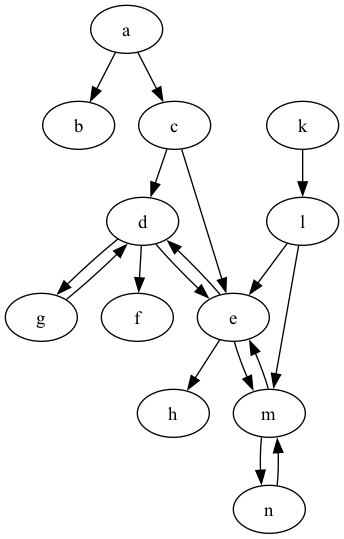

In [6]:
render_dot_to_png("graphs/wm_graph.dot", "graphs/wm_graph.png")
Image("graphs/wm_graph.png")

**Attack_Graph**

In [7]:
create_plain_graph(
    "files/plain_wm_graph.dlv", "edge", "graphs/attack_graph.dot", arg=True
)

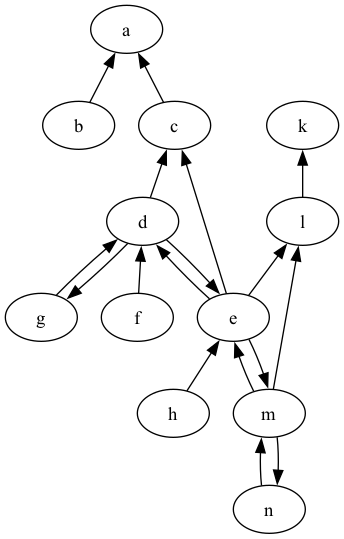

In [8]:
render_dot_to_png("graphs/attack_graph.dot", "graphs/attack_graph.png")
Image("graphs/attack_graph.png")

## Graph Coloring : Well-Founded Semantics

Here we will use the kernel as an example to help you better understand the tool

### Step by Step

#### Get Node Status

Because `e(X,Y) :- edge(X,Y).`, the graph for kernel calculation will be the same as the plain win-move graph we have drawn previously.

In [9]:
%%file files/plain_to_kernel.dlv

e(X,Y):- edge(Y,X).

Overwriting files/plain_to_kernel.dlv


Based on Combinatorial Game Theory Foundations Applied to Digraph Kernels by Dr.Fraenkel, we know that Kernel is both indepedent and dominating, which can be defined as

In [10]:
%%file files/cal_kernel.dlv

% c represents complements of kernels
% k stands for kernel
% pk means possibly in or out of kernel

% Positions
pos(X) :- e(X,_).
pos(X) :- e(_,X).

% Kernel rules
c(X) :- e(Y,X), k(Y).         % X is in the kernel complement if there is an edge from X into the kernel (to Y)
k(X) :- pos(X), not c(X).
pk(X) :- pos(X), not c(X), not k(X).

Overwriting files/cal_kernel.dlv


`-wf` indicates that the dlv will use well-founded semantics

In [11]:
cmd_solve = "dlv files/plain_wm_graph.dlv files/plain_to_kernel.dlv files/cal_kernel.dlv -wf"

let's run it with DLV, we will get the following output

In [12]:
run_command(cmd_solve)

'DLV [build BEN/Dec 17 2012   gcc 4.2.1 (Apple Inc. build 5666) (dot 3)]\n\nTrue: {edge(a,c), edge(a,b), edge(c,d), edge(c,e), edge(k,l), edge(l,e), edge(l,m), edge(d,e), edge(d,f), edge(d,g), edge(e,d), edge(e,m), edge(e,h), edge(m,e), edge(m,n), edge(g,d), edge(n,m), e(c,a), e(b,a), e(l,k), e(d,c), e(d,e), e(d,g), e(e,c), e(e,l), e(e,d), e(e,m), e(m,l), e(m,e), e(m,n), e(f,d), e(g,d), e(h,e), e(n,m), pos(a), pos(c), pos(b), pos(k), pos(l), pos(d), pos(e), pos(m), pos(f), pos(g), pos(h), pos(n), c(a), k(c), k(b), c(d), c(e), k(f), k(g), k(h)}\nUndefined: {c(k), k(k), c(l), k(l), c(m), k(m), c(n), k(n), pk(k), pk(l), pk(m), pk(n)}\n'

however, we need to filterout unnecessary information

In [13]:
kernel_nodes_status = get_nodes_status(
    run_command(cmd_solve), node_types=["c", "k", "pk"]
)

thus we know the status of each nodes, which we will use for further coloring the graph

In [14]:
kernel_nodes_status

{'c': ['a', 'd', 'e'],
 'k': ['c', 'b', 'f', 'g', 'h'],
 'pk': ['k', 'l', 'm', 'n']}

#### Visualization Schema

In [15]:
kernel_node_color_wfs = {"c": "white", "k": "black", "pk": "gray"}
kernel_edge_color_wfs = {
    ("white", "white"): "gray",
    ("white", "gray"): "gray",
    ("gray", "white"): "gray",
    ("gray", "gray"): "dark_blue",
    ("white", "black"): "dark_gray",
    ("black", "white"): "black",
}

In [16]:
apply_color_schema(
    "graphs/wm_graph.dot",
    "kernel",
    kernel_nodes_status,
    kernel_node_color_wfs,
    kernel_edge_color_wfs,
)

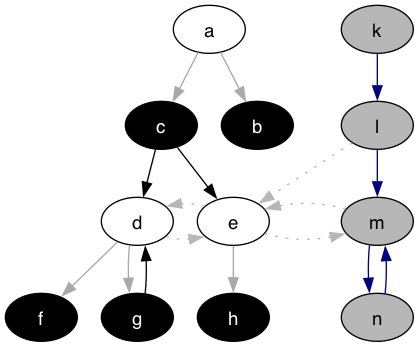

In [17]:
Image("graphs/kernel_graph_colored.png")

### One Function for All

As we have win_move graph and attack graph, we start to think about maybe we only need to provide the visualization schema and one function can provide us the expected graph

**WM game**

We will unveil the `visualize_wfs` function to illustrate well-founded semantics, requiring the specification of three values along with their color coding. Conversely, for stable models, the `visualize_stb` function requires just two values to be provided.

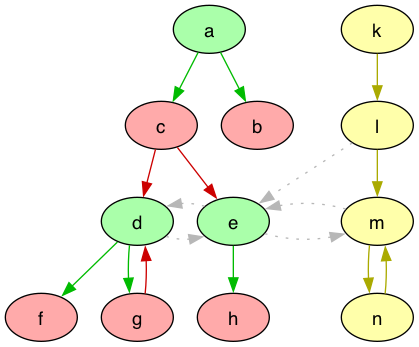

In [18]:
game_node_color_wfs = {"win": "green", "lost": "red", "drawn": "yellow"}
game_edge_color_wfs = {
    ("green", "green"): "gray",
    ("green", "yellow"): "gray",
    ("yellow", "green"): "gray",
    ("yellow", "yellow"): "yellow",
    ("green", "red"): "green",
    ("red", "green"): "red",
}
visualize_wfs(
    "files/plain_wm_graph.dlv",
    "game",
    game_node_color_wfs,
    game_edge_color_wfs
)
Image("graphs/game_graph_colored.png")

Having chosen the color for the edges, you are now able to display either the node label or the edge label.

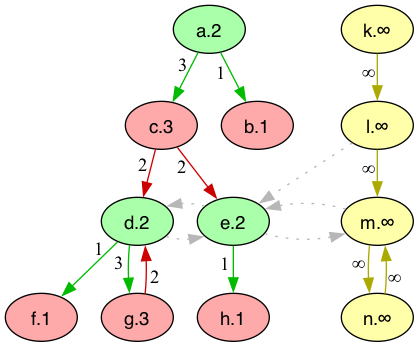

In [19]:
game_node_color_wfs = {"win": "green", "lost": "red", "drawn": "yellow"}
game_edge_color_wfs = {
    ("green", "green"): "gray",
    ("green", "yellow"): "gray",
    ("yellow", "green"): "gray",
    ("yellow", "yellow"): "yellow",
    ("green", "red"): "green",
    ("red", "green"): "red",
}
visualize_wfs(
    "files/plain_wm_graph.dlv",
    "game",
    game_node_color_wfs,
    game_edge_color_wfs,
    show_edge_label=True,
    show_node_label=True,
)
Image("graphs/game_graph_colored.png")

You can also add more layout to the graph

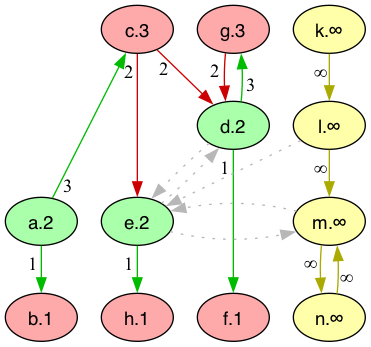

In [20]:
game_node_color_wfs = {"win": "green", "lost": "red", "drawn": "yellow"}
game_edge_color_wfs = {
    ("green", "green"): "gray",
    ("green", "yellow"): "gray",
    ("yellow", "green"): "gray",
    ("yellow", "yellow"): "yellow",
    ("green", "red"): "green",
    ("red", "green"): "red",
}
visualize_wfs(
    "files/plain_wm_graph.dlv",
    "game",
    game_node_color_wfs,
    game_edge_color_wfs,
    show_edge_label=True,
    show_node_label=True,
    rank=True
)
Image("graphs/game_graph_colored.png")

**Argumentation**

From the game graph, by adding `arg=True`, you can effortlessly obtain the argumentation framework version.

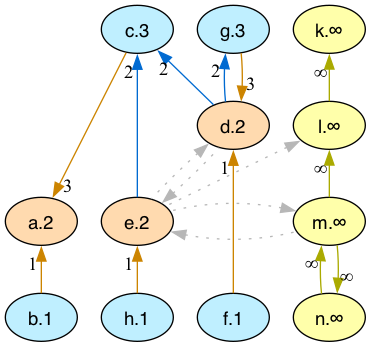

In [21]:
arg_node_color_wfs = {
    "accepted": "blue",
    "defeated": "orange",
    "undefined": "yellow",
}
arg_edge_color_wfs = {
    ("blue", "blue"): "gray",
    ("blue", "yellow"): "gray",
    ("yellow", "blue"): "gray",
    ("yellow", "yellow"): "yellow",
    ("blue", "orange"): "orange",
    ("orange", "blue"): "blue",
}
visualize_wfs(
    "files/plain_wm_graph.dlv",
    "arg",
    arg_node_color_wfs,
    arg_edge_color_wfs,
    arg=True,
    show_edge_label=True,
    show_node_label=True,
    rank=True
)
Image("graphs/arg_graph_colored.png")

### Graph Coloring: Stable Models

#### Get Node Status

similar to the WFS, but we need to remove the solve part `-wf`

In [22]:
cmd_solve = 'dlv files/plain_wm_graph.dlv files/plain_to_kernel.dlv files/cal_kernel.dlv -filter="k"'

let's run the command

In [23]:
print(run_command(cmd_solve))

DLV [build BEN/Dec 17 2012   gcc 4.2.1 (Apple Inc. build 5666) (dot 3)]

{k(c), k(b), k(k), k(m), k(f), k(g), k(h)}

{k(c), k(b), k(l), k(f), k(g), k(h), k(n)}



After the command, we can get the possible worlds

#### One Function for All

Similar to the WFS, we also want to generate all the stable models with defined visualization schema

**Stable Models for Kernel Graph**

In [24]:
kernel_node_color_stb = {"c": "white", "k": "black"}
kernel_edge_color_stb = {
    ("white", "white"): "gray",
    ("white", "gray"): "gray",
    ("gray", "white"): "gray",
    ("gray", "gray"): "dark_yellow",
    ("white", "black"): "dark_gray",
    ("black", "white"): "black",
}
visualize_stb(
    "files/plain_wm_graph.dlv",
    "kernel",
    kernel_node_color_stb,
    kernel_edge_color_stb,
    show_node_label=True,
    rank=True
)

**Stable Models for WM Graph**

In [25]:
game_node_color_stb = {"win": "green", "lost": "red"}
game_edge_color_stb = {
    ("green", "green"): "gray",
    ("green", "yellow"): "gray",
    ("yellow", "green"): "gray",
    ("yellow", "yellow"): "yellow",
    ("green", "red"): "green",
    ("red", "green"): "red",
}
visualize_stb(
    "files/plain_wm_graph.dlv",
    "game",
    game_node_color_stb,
    game_edge_color_stb,
    show_node_label=True,
    rank=True
)

**Stable Models for Attack Graph**

In [26]:
arg_node_color_stb = {
    "accepted": "blue",
    "defeated": "orange",
    "undefined": "yellow",
}
arg_edge_color_stb = {
    ("blue", "blue"): "gray",
    ("blue", "yellow"): "gray",
    ("yellow", "blue"): "gray",
    ("yellow", "yellow"): "yellow",
    ("blue", "orange"): "orange",
    ("orange", "blue"): "blue",
}
visualize_stb(
    "files/plain_wm_graph.dlv",
    "arg",
    arg_node_color_stb,
    arg_edge_color_stb,
    arg=True,
    show_node_label=True,
    rank=True
)